# СБОРНЫЙ ПРОЕКТ

Описание проекта:

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.
В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

### Шаг 1. 
### Загрузка данных.

In [1]:
# Импортируем необходимые для работы библиотеки

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from datetime import datetime, timedelta
import numpy as np
import random
import warnings
warnings.filterwarnings("ignore")
import requests 
from bs4 import BeautifulSoup
from scipy import stats as st

In [2]:
# Прочитаем файлы с данными

try:
    games = pd.read_csv('/datasets/games.csv')

except FileNotFoundError:
    
    games = pd.read_csv('games.csv')


In [3]:
games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
# изучим информацию
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


### Шаг 2. 
### Подготовим данные.

* **Заменим названия столбцов (приведем к нижнему регистру)**

In [5]:
# приведем к нижнему регистру
games.columns = games.columns.str.lower()

Также приведем к нижнему регистру все значения столбцов с категориальными данными, чтобы избежать неявных дубликатов. 

In [6]:
# Приведем к нижнему регистру следующие столбцы:
for column in games[['name','platform','genre','rating']]:
    games[column] = games[column].str.lower()

* **Преобразуем данные в нужные типы.**

In [7]:
# Приведем столбец с годом выпуска к типу дата 
#games.year_of_release = games.year_of_release.fillna(0)
games = games[~games.year_of_release.isna()]
games.year_of_release = games.year_of_release.astype('int')
#games.year_of_release = pd.to_datetime(games.year_of_release, format="%Y", errors='coerce')
#games.year_of_release = games.year_of_release.dt.to_period("Y")

In [8]:
games.rating.unique()

array(['e', nan, 'm', 't', 'e10+', 'k-a', 'ao', 'ec', 'rp'], dtype=object)

In [9]:
games.rating.value_counts()

e       3921
t       2905
m       1536
e10+    1393
ec         8
k-a        3
ao         1
rp         1
Name: rating, dtype: int64

In [10]:
# присвоим столбцу `user_score` тип - число с плавающей точкой
games.user_score = pd.to_numeric(games.user_score, errors='coerce')

* **Обработаем пропуски при необходимости**

In [11]:
games.isna().sum()

name                  2
platform              0
year_of_release       0
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8463
user_score         8983
rating             6678
dtype: int64

In [12]:
# Проверим строки с пропущенным названием фильма
games[games.name.isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,gen,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,gen,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Мы видим, что в строках с пропущенным названием игры, так же пропущена информация о жанрах. Мы можем смело удалять эти строки, так как они не дадут нам значимой для исследования информации. 

Строки с пропусками даты мы заменим датами, игр идентичных по названию, но на других платформах, там где год выпуска указан.

In [13]:
# удалим строки с пропущенными значениями названий игр и жанров
games = games[~games.name.isna()]

Заменим пропуски в столбцах с годом выпуска, оценками пользователей и критиков, на значения игр по одноименному названию для других платформ.

In [14]:
# Напишем функцию для замены пропущенных значений:
#def for_replace(parametr):
    # сделаем замену пропущенных значений параметра
#    for row in games[games[parametr].isna()].index:  
#        games[parametr][row] = games.loc[games['name'] == games['name'][row], parametr].max()
    # посчитаем оставшиеся пропуски
#    print(games[parametr].isna().sum())

In [15]:
#for_replace('year_of_release')
#for_replace('critic_score')
#for_replace('user_score')

В столбце `user_score` аббревиатуры 'tbd' не найдено.

In [16]:
games.user_score.unique()

array([8. , nan, 8.3, 8.5, 6.6, 8.4, 8.6, 7.7, 6.3, 7.4, 8.2, 9. , 7.9,
       8.1, 8.7, 7.1, 3.4, 5.3, 4.8, 3.2, 8.9, 6.4, 7.8, 7.5, 2.6, 7.2,
       9.2, 7. , 7.3, 4.3, 7.6, 5.7, 5. , 9.1, 6.5, 8.8, 6.9, 9.4, 6.8,
       6.1, 6.7, 5.4, 4. , 4.9, 4.5, 9.3, 6.2, 4.2, 6. , 3.7, 4.1, 5.8,
       5.6, 5.5, 4.4, 4.6, 5.9, 3.9, 3.1, 2.9, 5.2, 3.3, 4.7, 5.1, 3.5,
       2.5, 1.9, 3. , 2.7, 2.2, 2. , 9.5, 2.1, 3.6, 2.8, 1.8, 3.8, 0. ,
       1.6, 9.6, 2.4, 1.7, 1.1, 0.3, 1.5, 0.7, 1.2, 2.3, 0.5, 1.3, 0.2,
       0.6, 1.4, 0.9, 1. , 9.7])

Мы провели замену пропусков на значения среди одноименных игр, тем не менее у нас остается большое количество пропусков в столбцах `critic_score`, ``user_score``, `rating`.  

In [17]:
# найдем доли пропущенных значений в столбцах
for column in games[['critic_score', 'user_score', 'rating']].columns:
    share = games[column].isna().sum()/len(games[column])
    print(f'Доля пропусков в наборе данных {share:.1%}', 'для', column)

Доля пропусков в наборе данных 51.5% для critic_score
Доля пропусков в наборе данных 54.6% для user_score
Доля пропусков в наборе данных 40.6% для rating


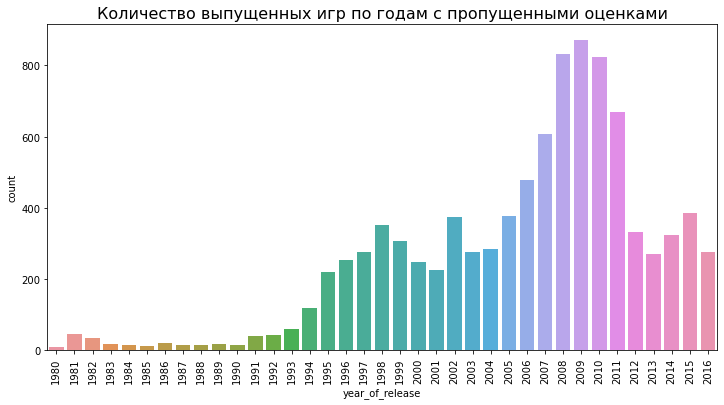

In [18]:
plt.figure(figsize=(12, 6))
sns.countplot(data=games[games.critic_score.isna() \
                         | games.user_score.isna()],
              x='year_of_release',
              order=games.sort_values(by='year_of_release').
              year_of_release.unique())
plt.title('Количество выпущенных игр по годам с пропущенными оценками', fontsize=16)
plt.xticks(rotation=90)
plt.show()

На диаграмме распределения мы можем увидеть, что пропуск в оценках не говорит, о том что данные устаревшие. За последние года, так же отсутствуют данные о пользовательских оценках и оценках критиков. 

In [19]:
# заменим пропущенные значения в столбце critic_score на средние значения в группах данных по наименованию платформы, жанру
#games.critic_score = (games.critic_score.                                                             # и году выпуска игры
#                        fillna(games.groupby(['platform', 'genre', 'year_of_release'])['critic_score'].
#                        transform("median"))
#                       )
# заменим пропущенные значения в столбце user_score на средние значения в группах данных по наименованию платформы, жанру
#games.user_score = (games.user_score.                                                                 # и году выпуска игры
#                        fillna(games.groupby(['platform', 'genre', 'year_of_release'])['user_score'].
#                        transform("median"))
#                       )

Заменим оставшиеся значения по средним значениям в группах по платформам и жанрам в незаполненных данных.

In [20]:
# заменим пропущенные значения в столбце critic_score на средние значения в группах данных по наименованию платформы, жанру
#games.critic_score = (games.critic_score.                                                             
#                        fillna(games.groupby(['platform', 'genre'])['critic_score'].
#                        transform("median"))
#                       )
# заменим пропущенные значения в столбце user_score на средние значения в группах данных по наименованию платформы, жанру
#games.user_score = (games.user_score.                                                                 
#                        fillna(games.groupby(['platform', 'genre'])['user_score'].
#                        transform("median"))
#                       )

In [21]:
#games.critic_score = round(games.critic_score, 2)
#games.user_score = round(games.user_score, 2)

In [22]:
# найдем доли пропущенных значений в столбцах
#for column in games[['critic_score', 'user_score', 'rating']].columns:
#    share = games[column].isna().sum()/len(games[column])
#    print(f'Доля пропусков в наборе данных {share:.1%}', 'для', column)

Удалим данные с пропущенными значениями оценок критиков и пользователей, так как нецелесообразно искать усредненную оценку только по наименованию платформы или жанру игры, так как оба эти признака могут влиять на величину оценок. Пропуски в столбце `rating` нет возможности восстановить, поэтому оставим пропуски незаполненными.

In [23]:
# удалим строки с пропущенными значениями оценок критиков и пользователей
#games = games[~games.critic_score.isna() & ~games.user_score.isna()]

In [24]:
games.duplicated().sum()

0

Явных дубликатов не обнаружено. Поищем неявные дубликаты.

In [25]:
games.genre.unique()

array(['sports', 'platform', 'racing', 'role-playing', 'puzzle', 'misc',
       'shooter', 'simulation', 'action', 'fighting', 'adventure',
       'strategy'], dtype=object)

In [26]:
games.rating.unique()

array(['e', nan, 'm', 't', 'e10+', 'k-a', 'ao', 'ec', 'rp'], dtype=object)

Из открытых источников спарсим таблицу с описанием рейтингов ESRB.

In [27]:
# возьмем из открытых источиков информацию с описание рейтингов ESRB
URL = 'https://www.kingston.com/ru/blog/gaming/understanding-video-games-age-ratings-esrb-pegi'
req = requests.get(URL) # сохраняем объект Response в переменную req. 
                        # Response — специальный объект, содержащий ответ сервера на HTTP-запрос
print('Код состояния', req.status_code)         # выведем атрибут - «код состояния» запроса

soup = BeautifulSoup(req.text, 'lxml')
table = soup.find('div',attrs={"c-table c-table--striped c-table--sideKeys"})

Код состояния 200


In [28]:
try:
    content=[] # Список, в котором будут храниться данные из таблицы
    for row in table.find_all('tr'): 
    # Каждая строка обрамляется тегом tr, необходимо пробежаться в цикле по всем строкам
        content.append([element.text for element in row.find_all('td')])
            # В каждой строке контент ячейки обрамляется тегами <td> </td>
            # Необходимо пробежаться в цикле по всем элементам td, вычленить контент из ячеек и добавить его в список 
            # Затем добавить каждый из списков в список content  
    rating = pd.DataFrame(content) 
    # в качестве данных передаем двумерный список content

    rating = rating.rename(columns={0:'rating', 1:'description'})
    rating['rating'] = rating['rating'].str.lower()
    rating['rating'] = rating['rating'].str.replace(" ", "")
    rating = rating.append({'rating':'k-a',
                        'description':'«Для детей и взрослых». Аналог Е, действовал до 1998 года'},
                       ignore_index=True)
    pd.set_option('display.max_colwidth', None)
    display(rating)
except:
    print('Код не сработал')

,rating,description
0,ec,"Для детей младшего возраста. Подходит для детей от 3 лет, неприемлемое содержание отсутствует. Примеры: Дора Исследовательница, Сказки Дракона."
1,e,"Подходит для всех возрастных категорий. Игра не должна содержать звуков или изображений, которые могут напугать маленьких детей. Не должна использоваться ненормативная лексика. Примеры: Просто таннцуй, FIFA."
2,e10+,"Подходит для лиц старше 10 лет. Игра может содержать умеренные формы насилия, а некоторые сцены могут пугать детей. Примеры: Minecraft Dungeons, Растения против зомби."
3,t,"Подходит для лиц старше 13 лет. Игра может содержать более реалистичные и натуралистические сцены насилия. Примеры: Fortnite, Sims 4."
4,m,"Подходит для лиц старше 17 лет. Этот рейтинг используется, когда насилие становится реалистичным и похожим на реальную жизнь. Также может присутствовать ненормативная лексика, употребление табака, алкоголя или запрещенных наркотиков. Примеры: Ark: Survival Evolved, Destiny 2."
5,ao,"Подходит для взрослых старше 18 лет. Классификация «для взрослых» используется, когда в игре присутствует крайний уровень насилия и немотивированного убийства. Также может присутствовать романтизация наркотиков, азартных игр и сексуальной активности. Примеры: Grand Theft Auto V, Fallout 4."
6,rp,Категория ещё не присвоена. Играм с категорией RP еще не присвоен окончательный рейтинг ESRB.
7,k-a,"«Для детей и взрослых». Аналог Е, действовал до 1998 года"


Можно объединить рейтинги `E` и `K-A`, так как они несут один смысл но в разные года обозначались по разному. А так же объединить `EC` и `E`, как как категория `EC` содержит малое количество знаений и по смыслу подходит к разновозростной категории. Рейтинг ``AO``, причислить к категории 17+, а ``RP`` - это по факту отсутствие информации о возрастной категории.

In [29]:
# заменяем устаревший рейтинг 'K-A' на 'E', 'EC' на 'E'
games.loc[games.rating == 'k-a', 'rating'] = 'e'
games.loc[games.rating == 'ec', 'rating'] = 'e'
games.loc[games.rating == 'ao', 'rating'] = 'm'
games.loc[games.rating == 'rp', 'rating'] = np.nan

In [30]:
games.rating.value_counts()

e       3932
t       2905
m       1537
e10+    1393
Name: rating, dtype: int64

In [31]:
games_ratings = games[['name', 'rating']].drop_duplicates()

In [32]:
games = games.drop(columns='rating').merge(games_ratings, on='name')

In [33]:
games['rating'] = games['rating'].fillna("Не указан")

Рассмотрим распределения значения оценок.

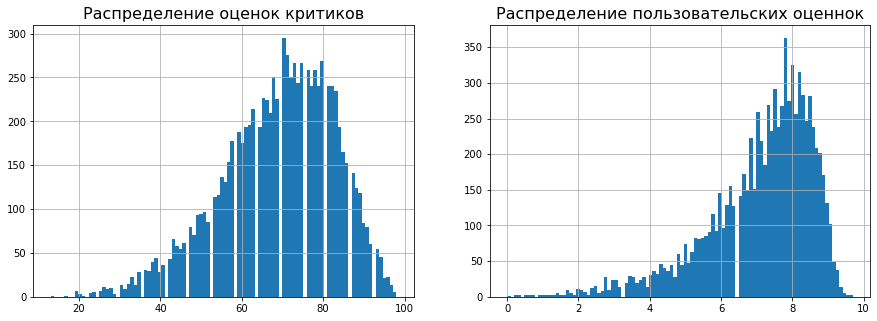

In [34]:
# задаём размер сетки для графиков
plt.figure(figsize=(15, 5))
ax1 = plt.subplot(1, 2, 1)
games.critic_score.hist(bins=100, ax=ax1)
plt.title("Распределение оценок критиков", fontsize=16)
ax2 = plt.subplot(1, 2, 2)
games.user_score.hist(bins=100, ax=ax2)
plt.title("Распределение пользовательских оценнок", fontsize=16)
plt.show()

Мы видим распределения величин, скошенные влево. Средняя величина оценок ниже медианных значений. Посмотрим описание количественных величин таблицы.

In [35]:
games[['na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'critic_score', 'user_score']].describe()

,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score
count,18237.000000,18237.000000,18237.000000,18237.000000,9156.000000,8557.000000
mean,0.271617,0.151555,0.075222,0.049642,68.885867,7.110529
std,0.802146,0.500401,0.302044,0.185238,13.912953,1.496229
min,0.000000,0.000000,0.000000,0.000000,13.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,60.000000,6.400000
50%,0.080000,0.020000,0.000000,0.010000,70.000000,7.500000
75%,0.250000,0.120000,0.030000,0.040000,79.000000,8.200000
max,41.360000,28.960000,10.220000,10.570000,98.000000,9.700000


Так же мы можем увидеть большой разброс значений в столбцах с количеством проданных копий. Необходим исследовательский анализ данных.

* **Посчитайте суммарные продажи во всех регионах и запишите их в отдельный столбец.**

In [36]:
# добавим столбец с суммарными продажами
games.insert(8, 'total_sales', games.na_sales + games.eu_sales + games.jp_sales + games.other_sales)

**Вывод:**

* Мы привели все текстовые значения к нижнему регистру, чтобы избежать неявных дубликатов, а так же чтобы привести названия столбцов к хорошему стилю;
* Привели данные к нужным типам;
* Восстановили пропуски, где это возможно;
* Проверили на явные и неявные дубликаты;
* Изучили распределения количественных виличин.


### Шаг 3. 
### Проведем исследовательский анализ данных.

* **Посмотрим, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?**

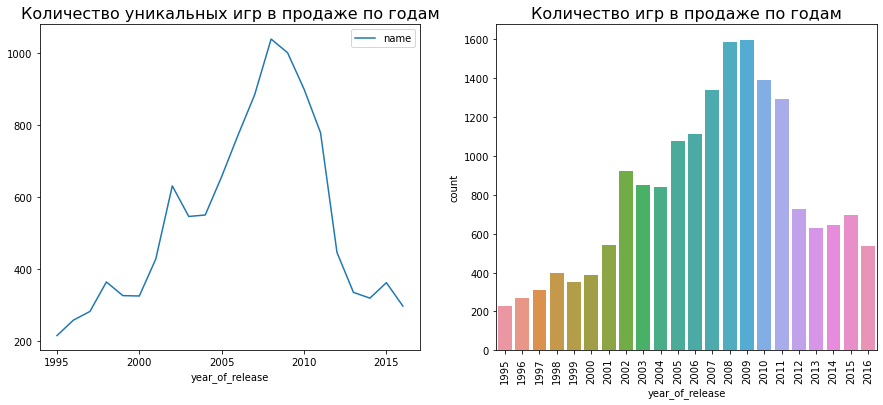

In [37]:
plt.figure(figsize=(15, 6))
ax1 = plt.subplot(1, 2, 1)
(
    games.
    query('year_of_release > 1994').
    pivot_table(index='year_of_release', values='name', aggfunc='nunique').
    plot(ax=ax1)
)
plt.title('Количество уникальных игр в продаже по годам', fontsize=16)
ax2 = plt.subplot(1, 2, 2)
(
    sns.
    countplot(data=games.query('year_of_release > 1994'),
              x='year_of_release',
              order=games.query('year_of_release > 1994').
              sort_values(by='year_of_release').
              year_of_release.
              unique(), ax=ax2)
)
plt.title('Количество игр в продаже по годам', fontsize=16)
plt.xticks(rotation=90)
plt.show()

Мы видим резкий рост количества выпущенных игр после 1994 года, пик пришелся на 2008 год, затем следует резкий спад. Это может быть связано с нарастаящей популярностью мобильных игр и приложений. Период в который выпускалось небольшое количество игр целесообразно исключить из исследования, так как устаревшая информация не даст нам представления, что влияло на динамику выпуска игр и сумму продаж.

* **Посмотрите, как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?**

In [38]:
sales = (
    games.
    pivot_table(index='platform', values='total_sales', aggfunc='sum').
    sort_values(by='total_sales', ascending=False)
)
# определим список платформ с наибольшими суммарными продажами
top_10_platform = (
    sales.
    reset_index().
    sort_values(by='total_sales', ascending=False).
    head(10)['platform'].
    to_list()
)

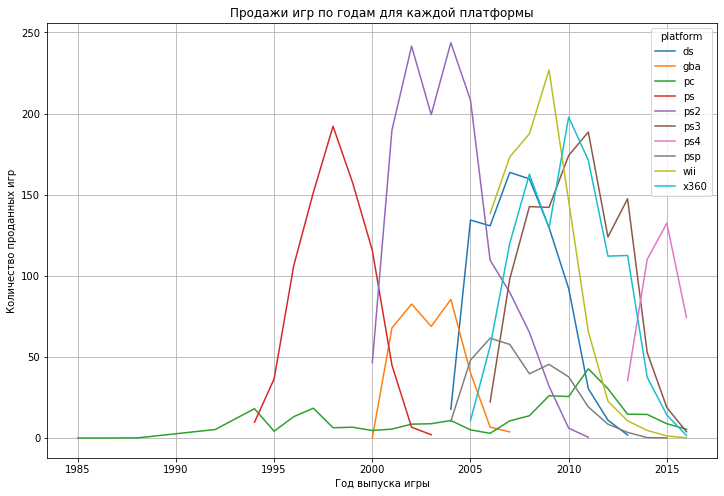

In [39]:
report = (
    games.query('platform in @top_10_platform').
    pivot_table(index='year_of_release',
                columns='platform', 
                values='total_sales', 
                aggfunc='sum')
)
report.plot(grid=True, figsize = (12,8))
plt.title('Продажи игр по годам для каждой платформы')
plt.xlabel('Год выпуска игры')
plt.ylabel('Количество проданных игр')
plt.show()

Из всех платформ больше всего выделяетс `PC`, выпуск игр на нее начался до 1990, и выпускаются по сей день. Но среди игроманов они не пользуются популярностью, и число проданных копий едва превышает 20 миллионов. За исключением 2011 года, где произошел небольшой скачок популрности. Больше всего продаж собрали игры на платформе `PS2`. Изобразим лидеров на диаграмме ниже:

Text(0, 0.5, 'Количество игр')

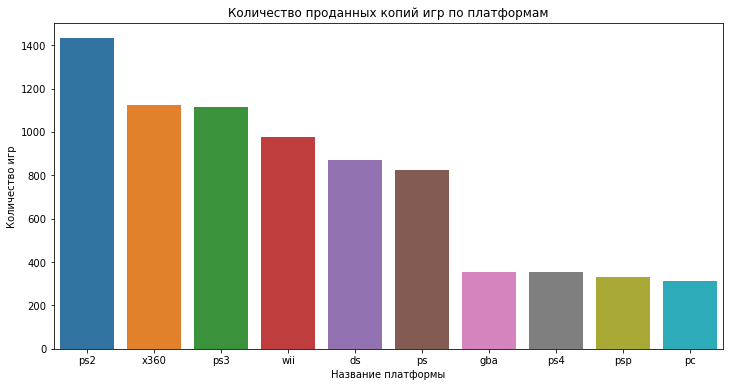

In [40]:
plt.figure(figsize=(12,6))
sns.barplot(x=sales.head(10).index,y=sales.head(10)['total_sales'])
plt.title("Количество проданных копий игр по платформам")
plt.xlabel("Название платформы")
plt.ylabel("Количество игр")

Мы выделили 6 платформ с наибольшими продажами выпускаемых на них игр - `ps2`,`x360`,`ps3`,`wii`,`ds`,`ps`

In [41]:
game_release_period = (
    games.
    query('platform in @top_10_platform').
    groupby('platform').
    agg({'year_of_release': ['min', 'max']}).
    reset_index()
)
game_release_period.columns = ['platform', 'min_year', 'max_year']
game_release_period[['min_year', 'max_year']] = game_release_period[['min_year', 'max_year']].astype(int)
game_release_period['period'] = game_release_period.max_year - game_release_period.min_year
print('Средний срок с момента появления \
платформы до ее ухода с рынка среди 10 самых \
продаваемых платформ равен', game_release_period.period.median(), 'годам')

Средний срок с момента появления платформы до ее ухода с рынка среди 10 самых продаваемых платформ равен 10.5 годам


Итак мы выявили, что между моментом выхода платфрмы на рынок до спада ее популярности проходит в среднем 10 лет. Мы выделили 6 консолей с наибольшими продажами игр за весь период.

* **Возьмите данные за соответствующий актуальный период. Актуальный период определите самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год. Не учитывайте в работе данные за предыдущие годы.**

Для построения динамики изменения объема продаж исключим данные за 2016 год, так как они могут содержать неполные данные за год, и будут искажать динамику показателей, а так же данные до 1994 года.

In [42]:
# убираем данные о играх до 1994 и играх без указания года выпуска
#games_analysis = games[~games.year_of_release.isna()]
games_analysis = (
    games[(games['year_of_release'] > 1993)
                   & (games['year_of_release'] != 2016)]
)

* **Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ.**

In [43]:
#report2 = (
#    games_analysis.
#    pivot_table(index='year_of_release',
#                columns='platform', 
#                values='total_sales', 
#                aggfunc='sum')
#)
#report2.plot(grid=True, figsize = (15,10))
#plt.title('Продажи игр по годам для каждой платформы')
#plt.xlabel('Год выпуска игры')
#plt.ylabel('Количество проданных игр')
#plt.show()

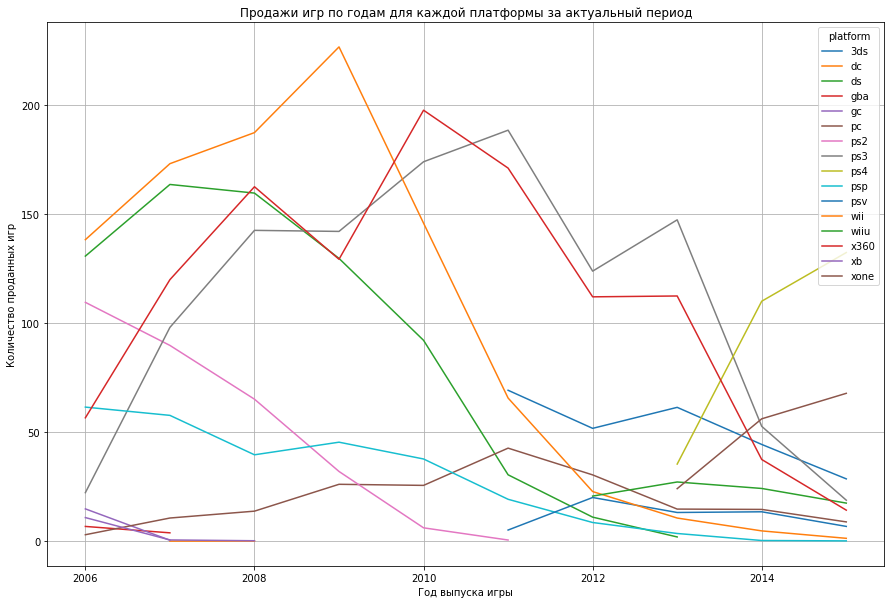

In [44]:
report3 = (
    games_analysis.query('year_of_release > 2005').
    pivot_table(index='year_of_release',
                columns='platform', 
                values='total_sales', 
                aggfunc='sum')
)
report3.plot(grid=True, figsize = (15,10))
plt.title('Продажи игр по годам для каждой платформы за актуальный период')
plt.xlabel('Год выпуска игры')
plt.ylabel('Количество проданных игр')
plt.show()

По динамике продаж мы можем видеть, что продажи всех платформ резко падают к 2015 году, тогда как продажи платформ `XOne` и `PS4` растут. Следовательно, можно выделить их как потенциально прибыльные. Так же можно рассмотреть платформы вышедшие в 2011 году и набравшие популярность - `psv` PlayStation Vita и `3ds` Nintendo 3DS - мобильные косоли. А так же `pc`, которая на протяжении долгих лет стабильно продается.

Выделим актуальный период для анализа перспективных платформ

In [45]:
games_analysis = games.query("year_of_release > 2006 and platform in ('xone', 'ps4', 'pc', 'psv', '3ds')")

* **Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишите результат.**

In [46]:
games_analysis['platform'].unique()

array(['ps4', 'xone', 'pc', '3ds', 'psv'], dtype=object)

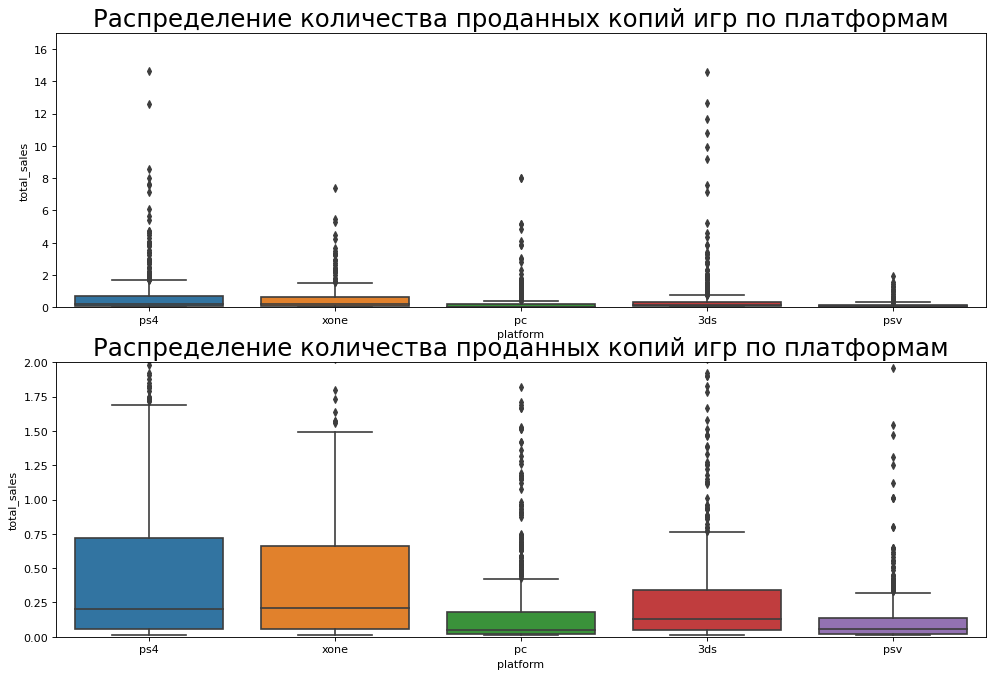

In [47]:
plt.figure(figsize=(15,10), dpi= 80)
ax1 = plt.subplot(2, 1, 2)
sns.boxplot(x='platform', y='total_sales', data=games_analysis, notch=False, ax=ax1)
plt.title('Распределение количества проданных копий игр по платформам', fontsize=22)
plt.ylim(0, 2)
ax2 = plt.subplot(2, 1, 1)
sns.boxplot(x='platform', y='total_sales', data=games_analysis, notch=False, ax=ax2)
plt.title('Распределение количества проданных копий игр по платформам', fontsize=22)
plt.ylim(0, 17)
plt.show()

На первом графике мы можем увидеть сильно выбивающиеся значения для платформы `ps4` и `3ds`, это говорит о том, что выходило некоторое количество игр с большим число продаж - более 10 миллионов проданных копий. Основная часть игр продавалось в количестве не более 750 тыс.копий. Лучшие по продажам для одной игры с 2016 года - `ps4` и `xone`.

* **Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.**

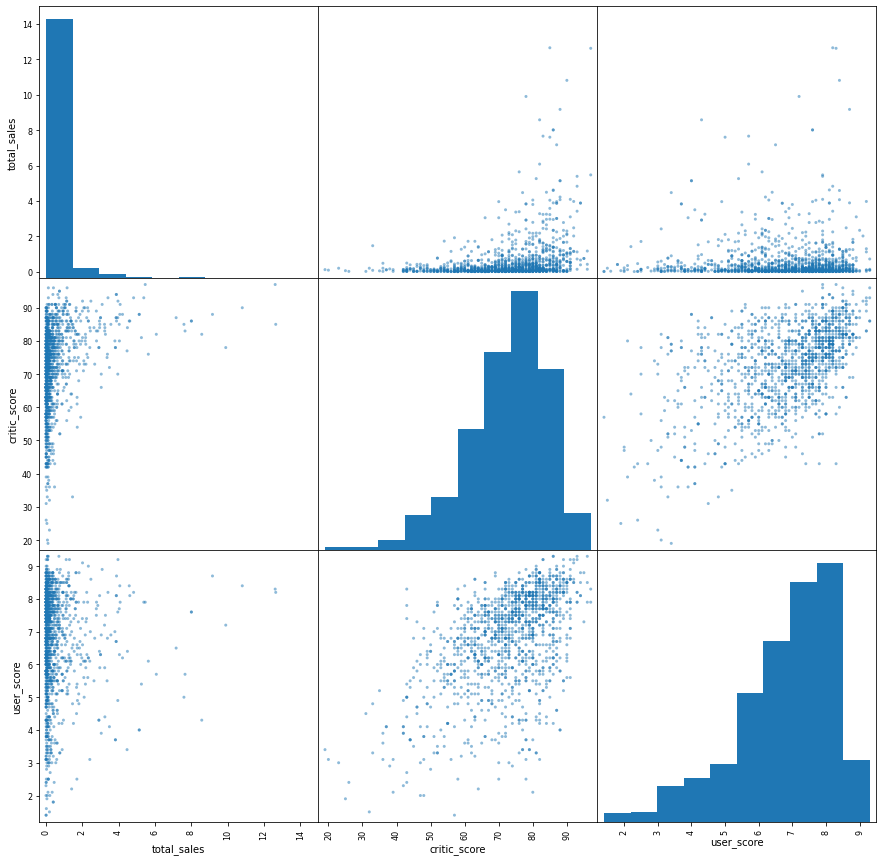

In [48]:
(                                                                # построим матрицу диаграм рассеяния для следубщих столбцов
    pd.plotting.                                                 # 'total_sales',
    scatter_matrix                                               # 'critic_score', 'user_score'
    (games_analysis.
     loc[:, ('total_sales','critic_score','user_score')], figsize=(15, 15))
) 
plt.show()

На диаграммах рассеяния мы видим не ярковыраженную связь общих продаж и оценок игр, нельзя однозначно сказать какие оценки оказывают наибольшее влиние на продажи игр. Посчитаем коээффициенты корреляции для взаимосвязи показателей.

In [49]:
(
    games_analysis.
    loc[:, ('total_sales','critic_score','user_score')].
    corr()
)

,total_sales,critic_score,user_score
total_sales,1.000000,0.289528,-0.001815
critic_score,0.289528,1.000000,0.522215
user_score,-0.001815,0.522215,1.000000


Взаимосвязь величины оценок критиков и количества проданных копий слабовыраженная положительная (чем выше оценки, тем больше продажи), коэффициент корреляции не доходит до 0.3. Оценки критиков оказаывают бОльшее влияние на продажи игр. Рассмотрим влияние оценкок на продажи всех платформ за период с 2016 года.

* **Соотнесите выводы с продажами игр на других платформах.**

In [50]:
games_analys = games.query('year_of_release > 2006')
d=[]
for platforms in games_analys.platform.unique():
    d.append({'Название пдатформы' : platforms,
              'Зависимость total_sales/critic_score': games_analys[games_analys['platform'] == platforms].
              total_sales.
              corr(games_analys[games_analys['platform'] == platforms].critic_score),
              'Зависимость total_sales/user_score': games_analys[games_analys['platform'] == platforms].
              total_sales.
              corr(games_analys[games_analys['platform'] == platforms].user_score),
              'Общие продажи' : games_analys[games_analys['platform'] == platforms]['total_sales'].sum()
             })
    
pd.DataFrame(d)

,Название пдатформы,Зависимость total_sales/critic_score,Зависимость total_sales/user_score,Общие продажи
0,wii,0.236735,0.144281,838.81
1,x360,0.399280,0.104916,1059.03
2,ps3,0.440791,0.115216,1092.46
3,ps4,0.407771,-0.050730,352.23
4,xone,0.418959,-0.086739,175.45
5,pc,0.290330,-0.009937,192.71
6,ds,0.274507,0.130939,588.83
7,3ds,0.348359,0.219065,270.97
8,wiiu,0.331604,0.382606,94.08
9,psv,0.125229,-0.002362,62.80


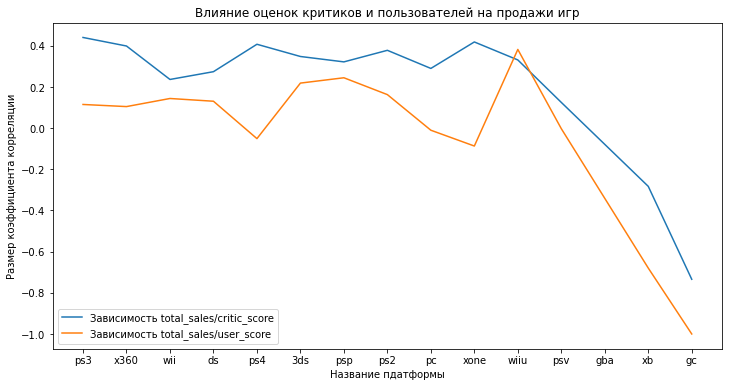

In [51]:
corr_df = pd.DataFrame(d)
plt.figure(figsize=(12, 6))
sns.lineplot(data=corr_df.
             sort_values(by='Общие продажи',
                         ascending=False),
             x='Название пдатформы',
             y='Зависимость total_sales/critic_score', label='Зависимость total_sales/critic_score')
sns.lineplot(data=corr_df.
             sort_values(by='Общие продажи', 
                         ascending=False), 
             x='Название пдатформы', 
             y='Зависимость total_sales/user_score', label='Зависимость total_sales/user_score')
plt.ylabel('Размер коэффициента корреляции')
plt.title('Влияние оценок критиков и пользователей на продажи игр')
plt.show()

Итак на графике мы видим как изменяется коэффициент корреляции между оценками и продажами от одной платформы к другой. С учетом того, что мы расположили платформы по размерам продаж игр по убыванию, нет возможности проследить тенденцию изменения зависимостей показателей от популярности платформ. Оценки критиков в большей степени оказывают влияние на продажи игр, чем пользовательские оценки. Для наших выбранных перспективных платформ `ps4` и `xone` мы можем видеть низкие коэффициенты зависимости продаж от пользовательских оценок, коэффициенты хоть и близки к нулю, но все же приобретают отрицательные значения, в то в время как оценки критиков наоборот оказывают бОльшее влияние на продажи среди всех платформ.

* **Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?**

Так как вкусовые предпочтения игроков постоянно меняются, целесообразно рассмотреть распределение жанров по популярности за последние 10 лет, включая 2016 год. Мы рассмотрим показатели общих продаж по жанрам, а так же средние продажи на одну выпущенную игру для указанного жанра.

In [52]:
# составим сводную таблицу для расчета средней величины продаж на одну выпущенную игру
multi_df = (
    games_analysis.
    pivot_table(index='genre',
                values='total_sales',
                aggfunc={'total_sales': ['sum', 'count']}).
    reset_index()
)

multi_df['game_sales'] = multi_df['sum']/multi_df['count']
multi_df = multi_df.sort_values(by='game_sales', ascending=False).reset_index(drop=True)
multi_df

,genre,count,sum,game_sales
0,shooter,215,194.99,0.906930
1,platform,69,47.80,0.692754
2,sports,202,118.07,0.584505
3,role-playing,364,202.19,0.555467
4,simulation,126,65.33,0.518492
5,fighting,72,27.43,0.380972
6,racing,127,46.00,0.362205
7,action,812,260.10,0.320320
8,misc,139,32.74,0.235540
9,strategy,150,26.75,0.178333


In [53]:
# зададим цветовую палитру, которая выбирает рандомный набор цветов
colors = lambda n: list(map(lambda i: "#" + "%06x" % random.randint(0, 0xFFFFFF),range(n)))
colors = colors(12)
colors = ListedColormap(colors)

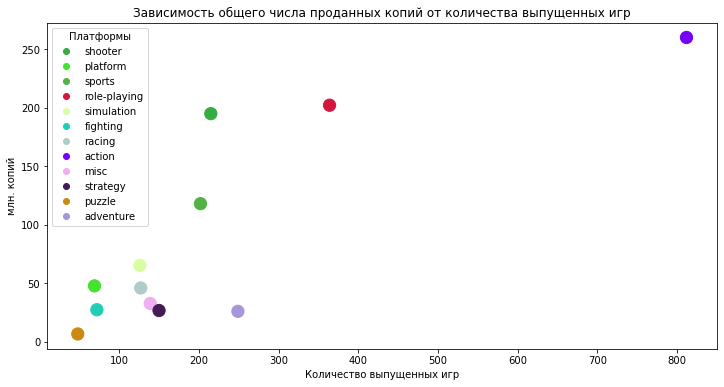

In [54]:
# построим точечную диаграмму, показывающая зависимость общих продаж от количества выпущенных игр
fig, ax= plt.subplots(figsize=(12, 6))
values = list(range(0, 12))
classes = multi_df['genre'].to_list()
scatter = ax.scatter(multi_df['count'], multi_df['sum'], s=150, cmap=colors, c=values)
ax.set(title='Зависимость общего числа проданных копий от \
количества выпущенных игр', xlabel='Количество выпущенных игр', ylabel='млн. копий')

#legend function
ax.legend(handles=scatter.legend_elements()[0], labels=classes, title='Платформы')
plt.show()

На диаграмме рассеяния мы можем видеть, что не всегда большое число выпущенных игр приносит много продаж. Жанр с наибольшими показателями, выделяющийся из всех прочих - `action`, большое число выпущенных игр, а так же наибольшие суммарные продажи. Но лидирует ли данный жанр по продажам одной выпущенной игры?

Визуализируем рейтинг по общим продажам и продажам на одну вышедшую игру ниже.

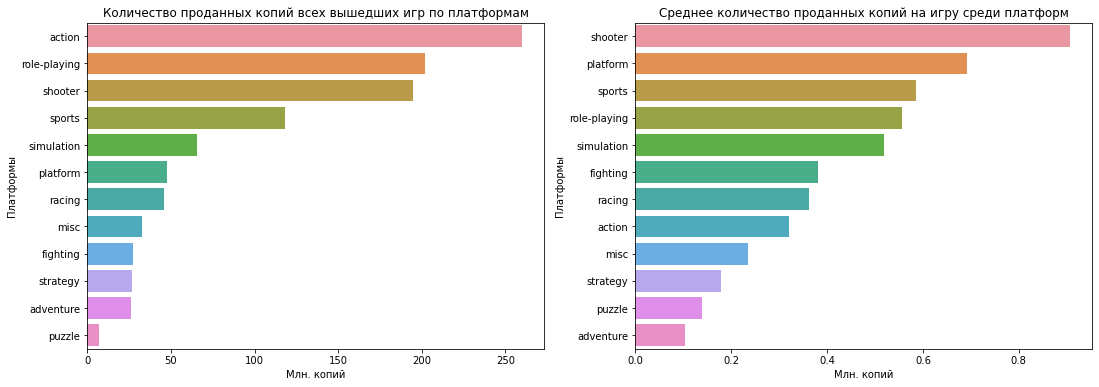

In [55]:
plt.figure(
    figsize=(18, 6)
)
ax1 = plt.subplot(1, 2, 1)
sns.barplot(multi_df['sum'], multi_df['genre'], order=multi_df.sort_values(by='sum',ascending=False)['genre'], ax=ax1)
plt.title("Количество проданных копий всех вышедших игр по платформам", fontsize=12) 
plt.ylabel('Платформы')
plt.xlabel('Млн. копий')

ax2 = plt.subplot(1, 2, 2)
sns.barplot(multi_df['game_sales'], multi_df['genre'], order=multi_df['genre'], ax=ax2)
plt.title("Среднее количество проданных копий на игру среди платформ", fontsize=12) 
plt.ylabel('Платформы')
plt.xlabel('Млн. копий')
plt.show()

Итак мы видим, что одна вышедшая игра жанра `shooter` приносит наибольший доход ее создателю. ``áction`` в этом рейтинге занимает только 6 позицию.

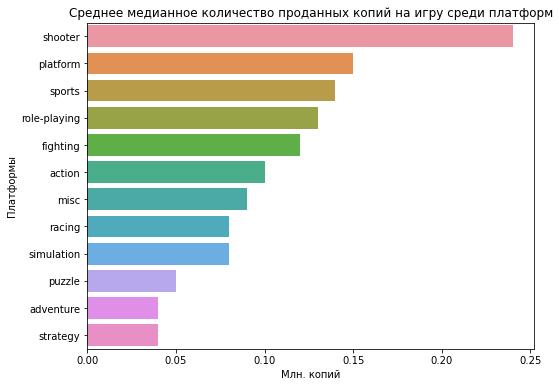

In [56]:
plt.figure(
    figsize=(8, 6)
)
median = (
    games_analysis.
    pivot_table(index='genre', values='total_sales', aggfunc={'total_sales': 'median'}).
    sort_values(by='total_sales', ascending=False).
    reset_index()
)
sns.barplot(median['total_sales'], median['genre'])
plt.title("Среднее медианное количество проданных копий на игру среди платформ", fontsize=12) 
plt.ylabel('Платформы')
plt.xlabel('Млн. копий')
plt.show()

Так же рассмотрим совсем свежие данные за 2016 год. Отличаются ли результаты от общей картины?

In [57]:
multi_df_2016 = (
    games_analysis[games_analysis['year_of_release'] == 2016].
    pivot_table(index='genre',
                values='total_sales',
                aggfunc={'total_sales': ['sum', 'count']}).
    reset_index()
)

multi_df_2016['game_sales'] = multi_df_2016['sum']/multi_df_2016['count']
multi_df_2016 = multi_df_2016.sort_values(by='game_sales', ascending=False).reset_index(drop=True)
multi_df_2016

,genre,count,sum,game_sales
0,shooter,44,37.79,0.858864
1,sports,37,21.57,0.582973
2,role-playing,55,21.92,0.398545
3,fighting,13,3.31,0.254615
4,platform,11,2.80,0.254545
5,action,163,27.47,0.168528
6,racing,24,2.79,0.116250
7,simulation,18,1.89,0.105000
8,strategy,13,1.13,0.086923
9,adventure,61,4.89,0.080164


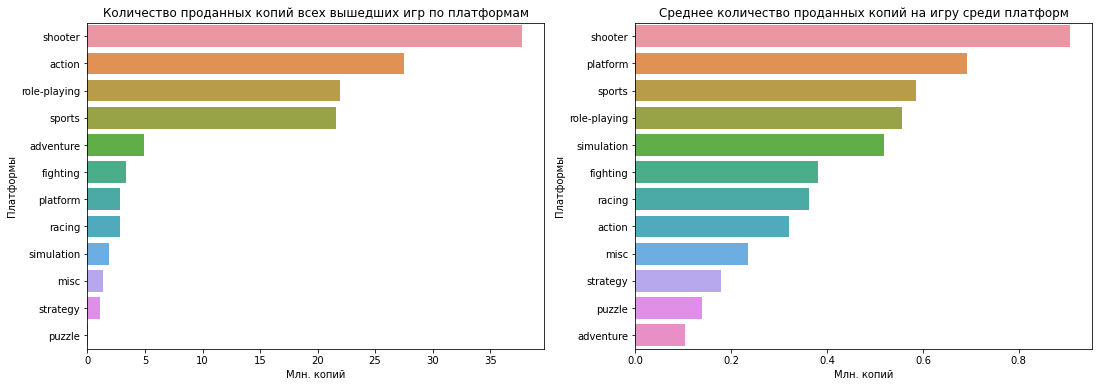

In [58]:
plt.figure(
    figsize=(18, 6)
)
ax1 = plt.subplot(1, 2, 1)
sns.barplot(multi_df_2016['sum'], multi_df_2016['genre'], order=multi_df_2016.sort_values(by='sum',ascending=False)['genre'], ax=ax1)
plt.title("Количество проданных копий всех вышедших игр по платформам", fontsize=12) 
plt.ylabel('Платформы')
plt.xlabel('Млн. копий')

ax2 = plt.subplot(1, 2, 2)
sns.barplot(multi_df['game_sales'], multi_df['genre'], order=multi_df['genre'], ax=ax2)
plt.title("Среднее количество проданных копий на игру среди платформ", fontsize=12) 
plt.ylabel('Платформы')
plt.xlabel('Млн. копий')
plt.show()

В целом, тенденция сохраняется, кроме того, что жанр `action` отходит на второй план, его сменяет жанр `shooter`. К тому же у этого жанра наибольший показатель продаж на одну игру. В целом в 2016 году можно выделить 4 особенно популярных жанра - `shooter`, `action`, `sports`, `role-playing`. Хотя по продажам на одну игру жанр `action` не входит в первую петерку. Его вытесняет жанр `fighting`.

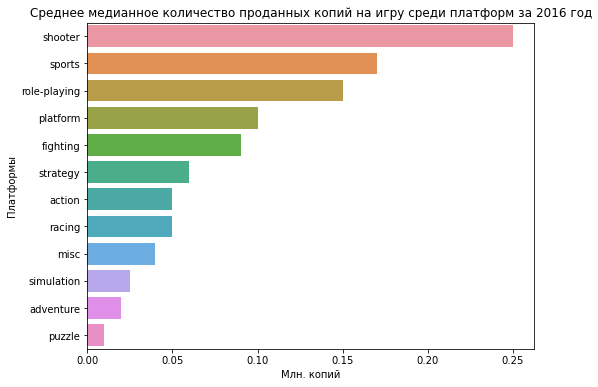

In [59]:
plt.figure(
    figsize=(8, 6)
)
median_2016 = (
    games_analysis.query('year_of_release == 2016').
    pivot_table(index='genre', values='total_sales', aggfunc={'total_sales': 'median'}).
    sort_values(by='total_sales', ascending=False).
    reset_index()
)
sns.barplot(median_2016['total_sales'], median_2016['genre'])
plt.title("Среднее медианное количество проданных копий на игру среди платформ за 2016 год", fontsize=12) 
plt.ylabel('Платформы')
plt.xlabel('Млн. копий')
plt.show()

**Вывод:**

Итак мы проделали работу, проанализировав данные:
* Мы выделили пять потенциально прибыльных платформы на 2017 год - `PS4` и `XOne`, `pc`, `psv`, `3ds`. Платформы `PS4` и `XOne` были введены в 2013 году, при среднем сроке жизни платформы в 10 лет, и высоких показателей продаж на одну выпущенную игру, они имеют все шансы собрать рекордные продажи;
* Платформы `psv`и `3ds` так же достаточно молодые, в продаже с 2011 года, и пик продаж может прийти именно на 2017 год. К тому же у них есть преимущества - они мобильные и имеют сравнительно невысоку истоимость. 
* Оценки критиков оказывают наибольшее влияние на величину продаж, при этом связь умеренная, не ярковыраженная;
* Не всегда большое количество выпущенных игр могут принести большие суммарные продажи, в зависимости от жанра. Мы вытелили топ жанров, пользующихся наибольшей популярностью среди игроманов - `shooter`,`platform`,`sports`, `role-playing`, `fightting`, `action`. 


### Шаг 4. 
### Составьте портрет пользователя каждого региона.

Определите для пользователя каждого региона (NA, EU, JP):

* **Самые популярные платформы (топ-5). Опишите различия в долях продаж.**
* **Самые популярные жанры (топ-5). Поясните разницу.**
* **Влияет ли рейтинг ESRB на продажи в отдельном регионе?**

In [60]:
#Напишем функцию для создания сводных таблиц и визуализации

def user_portrait(region, title):
    
    fig, axes = plt.subplots(3, 2, figsize=(18, 15))
    count = 1
    for parametr, ax in zip(['platform','platform','genre','genre','rating','rating'], axes.flatten()[:6]):
        if count % 2 == 0:
            df = games_analysis[games_analysis['year_of_release'] == 2016]
            colors = sns.color_palette('muted')[0:5]
        else:
            df = games_analysis
            colors = sns.color_palette('pastel')[0:5]
        pivot = (
            df.
            pivot_table(index=parametr, values=region, aggfunc='sum').
            sort_values(by=region, ascending=False).
            reset_index().
            head()
        )
        
        
        ax.pie(x=pivot[region], labels=pivot[parametr], colors = colors, autopct='%.0f%%', startangle = 180)
        fig.suptitle(title, fontsize=15)
        
        
        pd.set_option('display.max_colwidth', None)
        if parametr == 'rating':
            display(pivot.merge(rating))
        count += 1    
plt.show()
sns.set()

Составим потрет пользователя в регионе - Северная Америка.

,rating,na_sales,description
0,m,119.70,"Подходит для лиц старше 17 лет. Этот рейтинг используется, когда насилие становится реалистичным и похожим на реальную жизнь. Также может присутствовать ненормативная лексика, употребление табака, алкоголя или запрещенных наркотиков. Примеры: Ark: Survival Evolved, Destiny 2."
1,e,73.96,"Подходит для всех возрастных категорий. Игра не должна содержать звуков или изображений, которые могут напугать маленьких детей. Не должна использоваться ненормативная лексика. Примеры: Просто таннцуй, FIFA."
2,t,58.42,"Подходит для лиц старше 13 лет. Игра может содержать более реалистичные и натуралистические сцены насилия. Примеры: Fortnite, Sims 4."
3,e10+,36.29,"Подходит для лиц старше 10 лет. Игра может содержать умеренные формы насилия, а некоторые сцены могут пугать детей. Примеры: Minecraft Dungeons, Растения против зомби."


,rating,na_sales,description
0,m,17.06,"Подходит для лиц старше 17 лет. Этот рейтинг используется, когда насилие становится реалистичным и похожим на реальную жизнь. Также может присутствовать ненормативная лексика, употребление табака, алкоголя или запрещенных наркотиков. Примеры: Ark: Survival Evolved, Destiny 2."
1,t,8.47,"Подходит для лиц старше 13 лет. Игра может содержать более реалистичные и натуралистические сцены насилия. Примеры: Fortnite, Sims 4."
2,e,7.27,"Подходит для всех возрастных категорий. Игра не должна содержать звуков или изображений, которые могут напугать маленьких детей. Не должна использоваться ненормативная лексика. Примеры: Просто таннцуй, FIFA."
3,e10+,2.32,"Подходит для лиц старше 10 лет. Игра может содержать умеренные формы насилия, а некоторые сцены могут пугать детей. Примеры: Minecraft Dungeons, Растения против зомби."


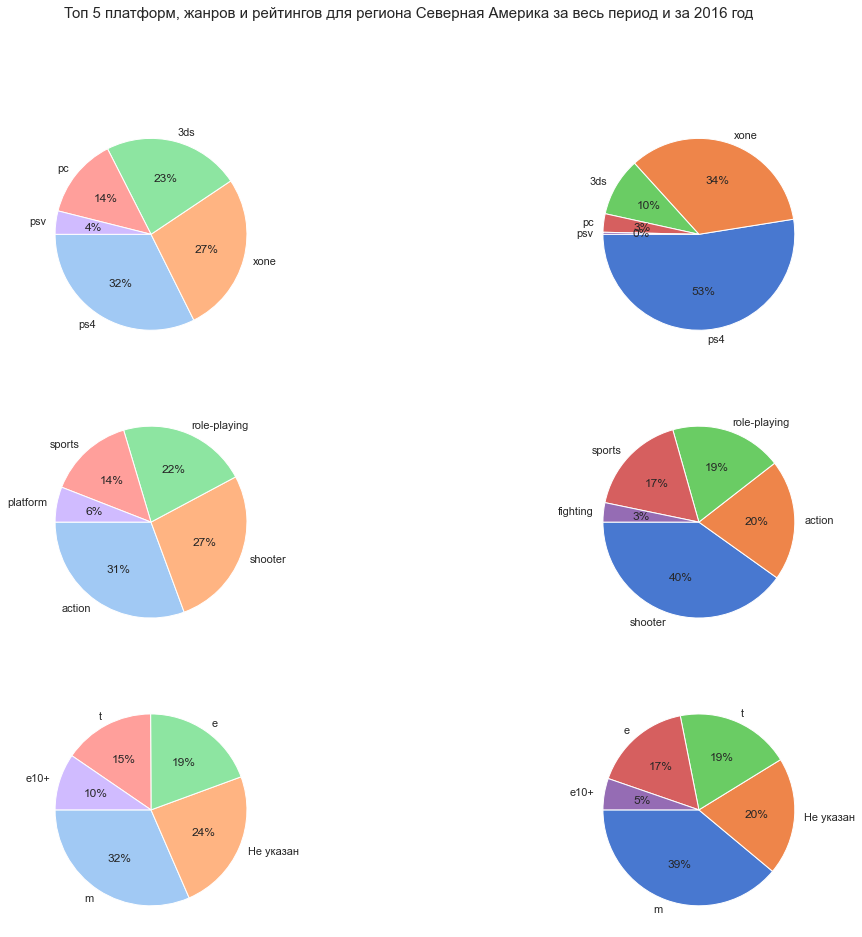

In [61]:
#Выведем топ 5 платформ, жанров и рейтингов за весь период до 2016 года, и за 2016 год
user_portrait('na_sales','Топ 5 платформ, жанров и рейтингов для региона Северная Америка за весь период и за 2016 год')

Мы рассмотрели самые продаваемые игры в разрезе разных параметров для Северной америки по данным за последние 10 лет. На диаграммах справа представленны распределения среди топовых игр по продажам за 2016 год. Сравним как изменились предпочтения для данного региона. Среди топовых платформ 53 % продаж пришлось на `ps4`. За ней 34% рынка заняла консоль `xone`. Если за все актуальное время самым востребованным был жанр `action`, то теперь игроки делаю выбор в пользу жанра `shooter` для возрастной категории 17+, где в играх присутствуют умеренные сцены насилия и ненормативной лексики.

Так же рассмотрим топ 5 продаваемых сегментов игр для Европы.

,rating,eu_sales,description
0,m,133.58,"Подходит для лиц старше 17 лет. Этот рейтинг используется, когда насилие становится реалистичным и похожим на реальную жизнь. Также может присутствовать ненормативная лексика, употребление табака, алкоголя или запрещенных наркотиков. Примеры: Ark: Survival Evolved, Destiny 2."
1,e,86.76,"Подходит для всех возрастных категорий. Игра не должна содержать звуков или изображений, которые могут напугать маленьких детей. Не должна использоваться ненормативная лексика. Примеры: Просто таннцуй, FIFA."
2,t,64.67,"Подходит для лиц старше 13 лет. Игра может содержать более реалистичные и натуралистические сцены насилия. Примеры: Fortnite, Sims 4."
3,e10+,31.09,"Подходит для лиц старше 10 лет. Игра может содержать умеренные формы насилия, а некоторые сцены могут пугать детей. Примеры: Minecraft Dungeons, Растения против зомби."


,rating,eu_sales,description
0,m,18.09,"Подходит для лиц старше 17 лет. Этот рейтинг используется, когда насилие становится реалистичным и похожим на реальную жизнь. Также может присутствовать ненормативная лексика, употребление табака, алкоголя или запрещенных наркотиков. Примеры: Ark: Survival Evolved, Destiny 2."
1,e,12.44,"Подходит для всех возрастных категорий. Игра не должна содержать звуков или изображений, которые могут напугать маленьких детей. Не должна использоваться ненормативная лексика. Примеры: Просто таннцуй, FIFA."
2,t,9.44,"Подходит для лиц старше 13 лет. Игра может содержать более реалистичные и натуралистические сцены насилия. Примеры: Fortnite, Sims 4."
3,e10+,2.48,"Подходит для лиц старше 10 лет. Игра может содержать умеренные формы насилия, а некоторые сцены могут пугать детей. Примеры: Minecraft Dungeons, Растения против зомби."


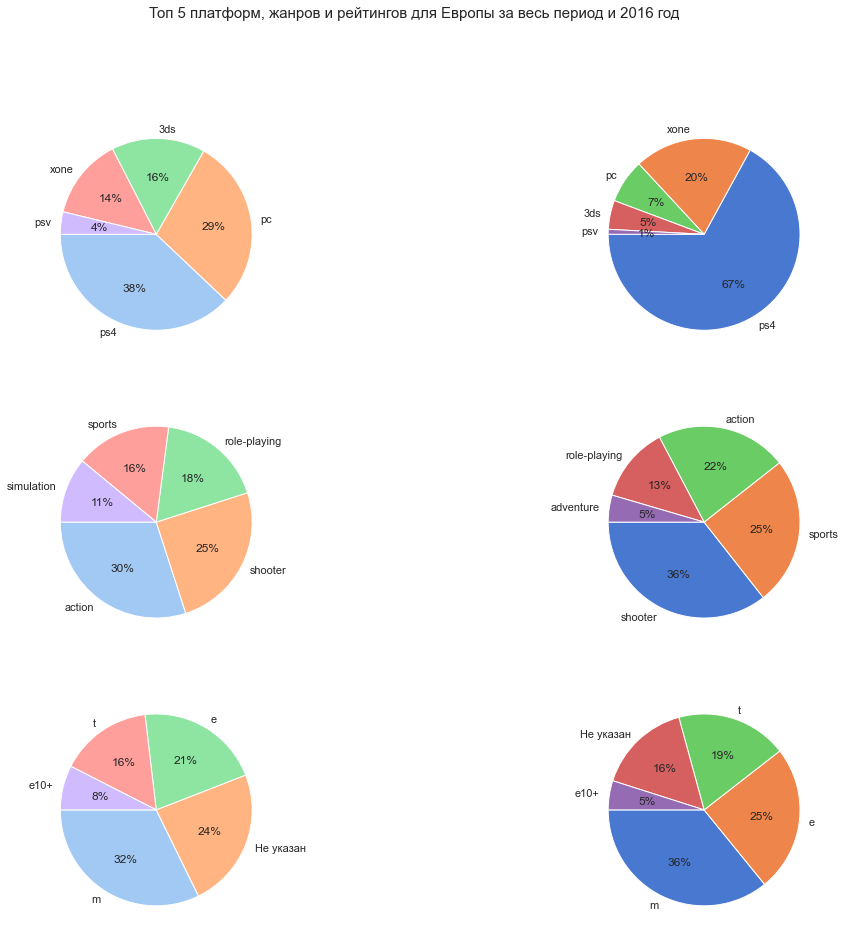

In [62]:
#Выведем топ 6 платформ, жанров и рейтингов за весь период до 2016
user_portrait('eu_sales','Топ 5 платформ, жанров и рейтингов для Европы за весь период и 2016 год')

Для европы 67 % всех копий проданных игр пришлось на `ps4`, и только 20% на `xone` в 2016 году. До текущего года в лидерах были `ps4` и `pc`. Самым популярным жанром стала стрельба, и для аудитории 17+.

Рассмотрим как изменились предпочтения в 2016 году для Японии.

,rating,jp_sales,description
0,e,23.73,"Подходит для всех возрастных категорий. Игра не должна содержать звуков или изображений, которые могут напугать маленьких детей. Не должна использоваться ненормативная лексика. Примеры: Просто таннцуй, FIFA."
1,t,19.76,"Подходит для лиц старше 13 лет. Игра может содержать более реалистичные и натуралистические сцены насилия. Примеры: Fortnite, Sims 4."
2,m,9.62,"Подходит для лиц старше 17 лет. Этот рейтинг используется, когда насилие становится реалистичным и похожим на реальную жизнь. Также может присутствовать ненормативная лексика, употребление табака, алкоголя или запрещенных наркотиков. Примеры: Ark: Survival Evolved, Destiny 2."
3,e10+,5.77,"Подходит для лиц старше 10 лет. Игра может содержать умеренные формы насилия, а некоторые сцены могут пугать детей. Примеры: Minecraft Dungeons, Растения против зомби."


,rating,jp_sales,description
0,t,2.30,"Подходит для лиц старше 13 лет. Игра может содержать более реалистичные и натуралистические сцены насилия. Примеры: Fortnite, Sims 4."
1,m,1.30,"Подходит для лиц старше 17 лет. Этот рейтинг используется, когда насилие становится реалистичным и похожим на реальную жизнь. Также может присутствовать ненормативная лексика, употребление табака, алкоголя или запрещенных наркотиков. Примеры: Ark: Survival Evolved, Destiny 2."
2,e,0.93,"Подходит для всех возрастных категорий. Игра не должна содержать звуков или изображений, которые могут напугать маленьких детей. Не должна использоваться ненормативная лексика. Примеры: Просто таннцуй, FIFA."
3,e10+,0.20,"Подходит для лиц старше 10 лет. Игра может содержать умеренные формы насилия, а некоторые сцены могут пугать детей. Примеры: Minecraft Dungeons, Растения против зомби."


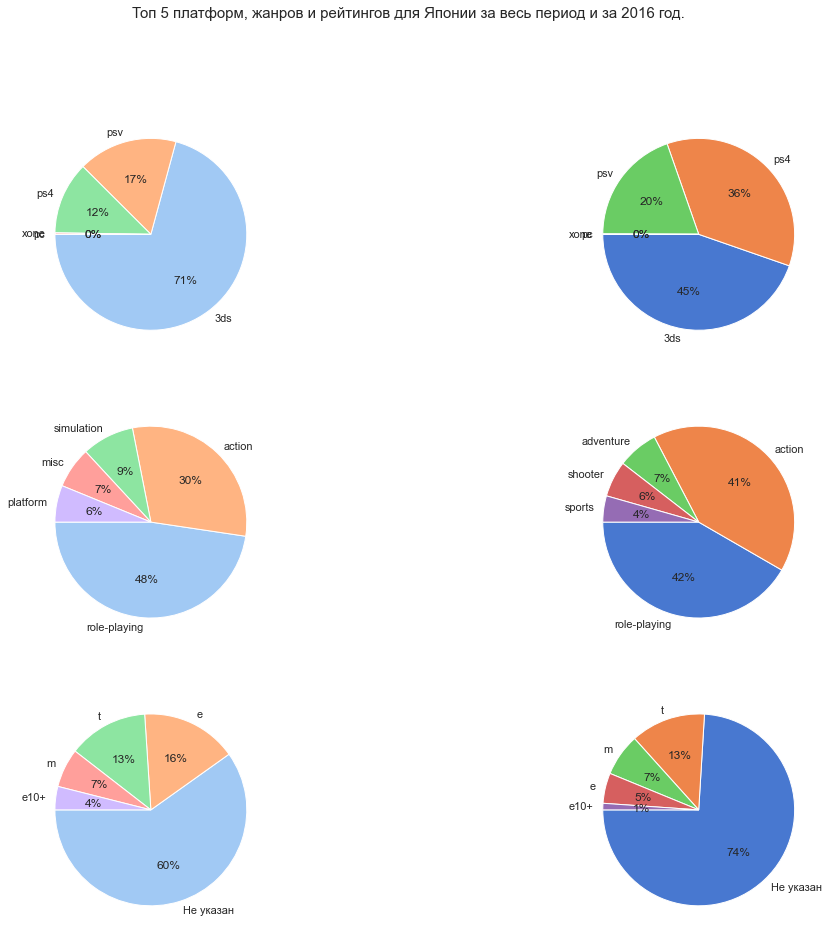

In [63]:
#Выведем топ 6 платформ, жанров и рейтингов за весь период до 2016
user_portrait('jp_sales','Топ 5 платформ, жанров и рейтингов для Японии за весь период и за 2016 год.')

В Японии пользуется популярность консоль `3ds`, при этом `ps4` не много уступает ей по популярности. Жанр `shooter` в отличии от других регионов здесь не востребован. Пользователи играют `action` и `role-playing` игры старше 13 лет.

**Вывод:**

* Аудитория Японии существенно отличается по игровым интересам от аудитории стран Европейского союза и Северной Америки. Если в последних популярен жанр `shooter` для лиц старше 17 лет, то в Японии популярны более мирные игры жанров `action` и `role-playing` для аудитории возраста старше 13 лет, которые тем не менее могут содержать реалистичные и натуралистические сцены насилия, а так же игры для всех возрастов.

Распределение категорий по platform :



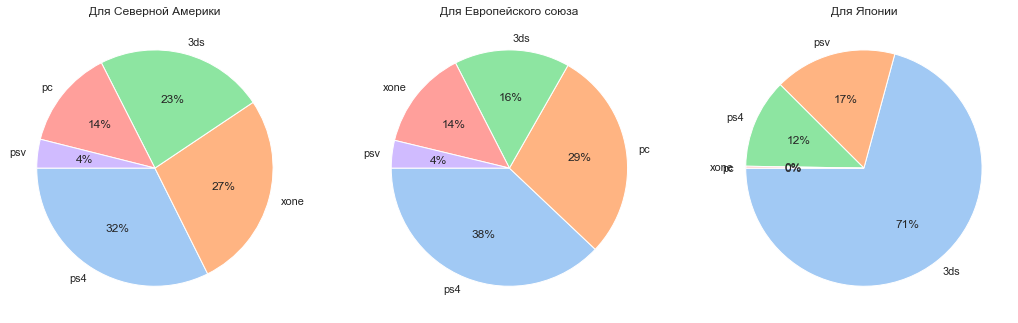

Распределение категорий по genre :



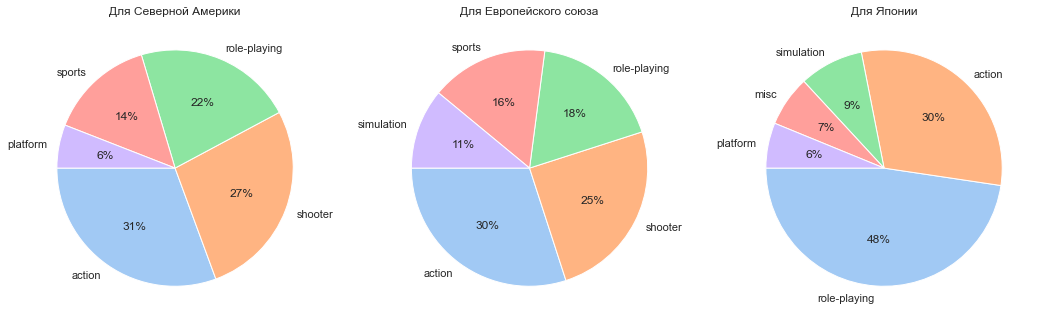

Распределение категорий по rating :



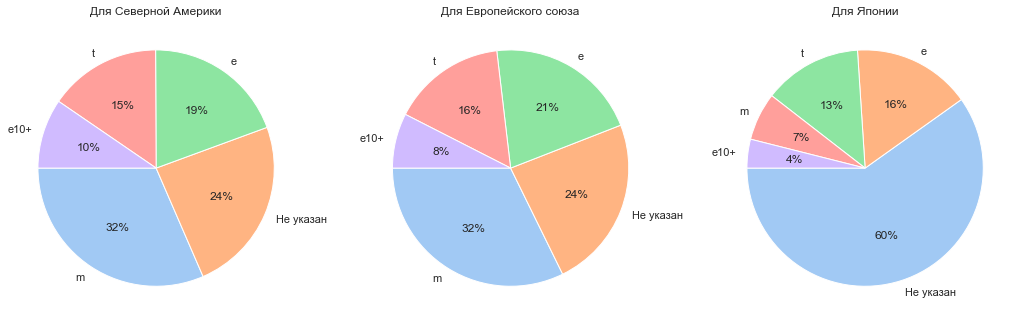

In [64]:

for parametr in ('platform', 'genre', 'rating'):
    plt.figure(
    figsize=(18, 6)
)
    print('Распределение категорий по', parametr, ':')
    print('')
    colors = sns.color_palette('pastel')[0:5]
    j=1
    for region, title in zip(
        ('na_sales', 'eu_sales', 'jp_sales'),
        ('Для Северной Америки', 'Для Европейского союза', 'Для Японии')
    ):
        pivot = (
                    games_analysis.
                    pivot_table(index=parametr, values=region, aggfunc='sum').
                    sort_values(by=region, ascending=False).
                    reset_index().
                    head()
                )
        ax = plt.subplot(1, 3, j)
        ax.pie(x=pivot[region], labels=pivot[parametr], autopct='%.0f%%', colors=colors, startangle = 180)
        plt.title(title)
    
        j += 1

    plt.show()

### Шаг 5. 
### Проверьте гипотезы.

* **Гипотеза 1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;**

Сформулируем нулевые гипотезы:

1. Нулевая гипотеза H₀: Средние пользовательские рейтинги платформ ``XOne`` и ``PC`` одинаковые;
2. Альтернативная гипотеза H₁: Средние пользовательские рейтинги платформ ``XOne`` и ``PC`` различаются.

Создадим выборки актуальных данных за последние 5 лет для каждой исследуемой платформы, и сохраним их в переменные. За последние пять лет, так как платформа Xone достаточно молодая, и вышла несколько лет назад. Чтобы уровнять выборки количественно зададим небольшой промежуток времени.

In [65]:
xone_select = (
    games_analysis[(games_analysis['platform']=='xone') & 
                   (~games_analysis.user_score.isna()) & 
                   (games_analysis['year_of_release'] > 2011)]
    ['user_score']
)
pc_select = (
    games_analysis[(games_analysis['platform']=='pc') & 
                   (~games_analysis.user_score.isna()) & 
                   (games_analysis['year_of_release'] > 2011)]
    ['user_score']
)

In [66]:
print('Средняя пользовательская оценка для платформы XOne', round(xone_select.mean(), 2))
print('Средняя пользовательская оценка для платформы PC', round(pc_select.mean(), 2))

Средняя пользовательская оценка для платформы XOne 6.55
Средняя пользовательская оценка для платформы PC 6.48


На первый взгляд можно увидеть, что средняя оценка пользователя для платформы XOne незначительно превышает среднюю оценку PC, но так как мы рассматриваем выборочную совокупность данных нельзя однозначно утверждать, что средние оценки отличаются, и что данные различия являются статистически значимыми, а не являются случайным явлением.

Сравним размеры выборок, чтобы понять достаточно ли нам данных для анализа.

In [67]:
print(len(xone_select))
len(pc_select)

204


232

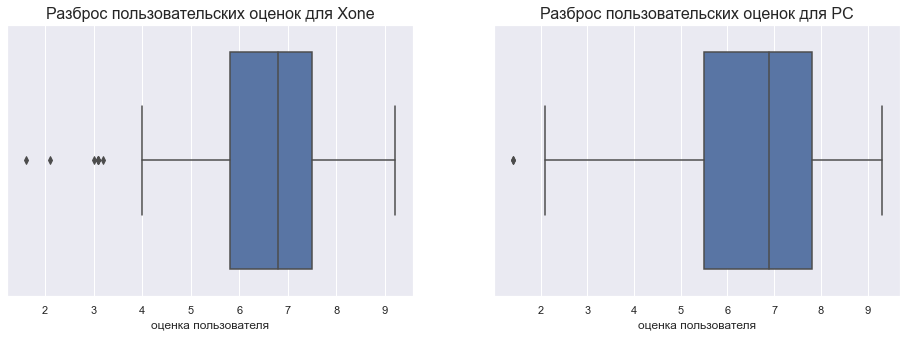

In [68]:
plt.figure(
    figsize=(16, 5)
)
ax1 = plt.subplot(1, 2, 1)
sns.boxplot(x=xone_select, ax=ax1)
plt.title("Разброс пользовательских оценок для Xone", fontsize=16) 
plt.xlabel('оценка пользователя')
ax2 = plt.subplot(1, 2, 2)
sns.boxplot(x=pc_select, ax=ax2)
plt.title("Разброс пользовательских оценок для PC", fontsize=16) 
plt.xlabel('оценка пользователя')
plt.show()

Мы видим в первом и во втором случае наличие аномальных значений оценок.

In [69]:
print('Дисперсия', np.var(xone_select, ddof=1))
print('Дисперсия', np.var(pc_select, ddof=1))

Дисперсия 1.8602441321356138
Дисперсия 2.747921891327063


Хоть выборки практически не отличаются по размеру, дисперсии имеют существенное отличие. Поэтому используем параметр equal_var со значением False.

In [70]:
results = st.ttest_ind(
    xone_select, 
    pc_select, 
    equal_var = False)

print('p-значение:', results.pvalue)

p-значение: 0.6139091469932472


In [71]:
alpha = 0.05
# если p-value окажется меньше него - отвергнем гипотезу

In [72]:
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

Не получилось отвергнуть нулевую гипотезу


In [73]:
probability = round(results.pvalue*100, 0)

In [74]:
print('Значение p-value показывает: вероятность случайно получить такое или большее \
различие близится к', probability, '%. Это явно слишком большая вероятность, чтобы делать вывод о значимом различии между \
средней пользовательской оценкой платформ XOne и PC.')

Значение p-value показывает: вероятность случайно получить такое или большее различие близится к 61.0 %. Это явно слишком большая вероятность, чтобы делать вывод о значимом различии между средней пользовательской оценкой платформ XOne и PC.


* **Гипотеза 2. Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.**

Сформулируем нулевые гипотезы:

1. Нулевая гипотеза H₀: Средние пользовательские рейтинги жанров `action` и `sports` одинаковые;
2. Альтернативная гипотеза H₁: Средние пользовательские рейтинги жанров ``action`` и ``sports`` различаются.

Возьмем актуальные данные за последние 10 лет. Так как жанр action пользуется большей популярностью у игроманов, выборки будут разного размера.

In [75]:
action_select = (
    games_analysis[(games_analysis['genre']=='action') & 
                   (~games_analysis.user_score.isna()) & 
                   (games_analysis['year_of_release'] > 2011)]
    ['user_score']
)
sports_select = (
    games_analysis[(games_analysis['genre']=='sports') & 
                   (~games_analysis.user_score.isna()) & 
                   (games_analysis['year_of_release'] > 2011)]
    ['user_score']
)

In [76]:
print('Средняя пользовательская оценка для платформы XOne', round(xone_select.mean(), 2))
print('Средняя пользовательская оценка для платформы PC', round(pc_select.mean(), 2))

Средняя пользовательская оценка для платформы XOne 6.55
Средняя пользовательская оценка для платформы PC 6.48


In [77]:
print(len(action_select))
len(sports_select)

324


124

Выпущенных игр в жанре action в два раза больше. Проверим разброс значений в выборках.

In [78]:
print('Дисперсия', np.var(action_select, ddof=1))
print('Дисперсия', np.var(sports_select, ddof=1))

Дисперсия 1.8507575583839766
Дисперсия 2.495999868869657


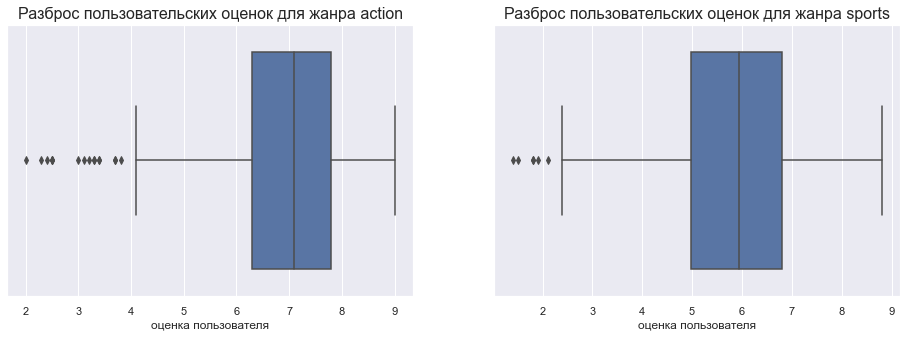

In [79]:
plt.figure(
    figsize=(16, 5)
)
ax1 = plt.subplot(1, 2, 1)
sns.boxplot(x=action_select, ax=ax1)
plt.title("Разброс пользовательских оценок для жанра action", fontsize=16) 
plt.xlabel('оценка пользователя')
ax2 = plt.subplot(1, 2, 2)
sns.boxplot(x=sports_select, ax=ax2)
plt.title("Разброс пользовательских оценок для жанра sports", fontsize=16) 
plt.xlabel('оценка пользователя')
plt.show()

Разброс оценок отличается незначительно, и дисперссия так же имеет небольшое различие.

Так как выборки отличаются по размеру, используем параметр equal_var со значением False.

In [80]:
results = st.ttest_ind(
    action_select, 
    sports_select, 
    equal_var = False)

print('p-значение:', results.pvalue)

p-значение: 3.8311147190452166e-12


In [81]:
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

Отвергаем нулевую гипотезу


In [82]:
probability = round(results.pvalue*100, 4)

In [83]:
print('Вероятность получить \
такие или более экстремальные значения случайной переменной при условии, что\
нулевая гипотеза верна, близится к', probability, '%. На основании этого мы отвергаем \
гипотезу о том, что средние пользовательские оценки этих двух жанров равны. \
 Между средними есть статистически значимые различия.')

Вероятность получить такие или более экстремальные значения случайной переменной при условии, чтонулевая гипотеза верна, близится к 0.0 %. На основании этого мы отвергаем гипотезу о том, что средние пользовательские оценки этих двух жанров равны.  Между средними есть статистически значимые различия.


**Вывод:**
- Гипотеза: "Средние пользовательские рейтинги платформ Xbox One и PC одинаковые". Не удалось выявить статистически значимые различия между средними пользовательскими рейтингами двух платформ.
- Гипотеза: "Средние пользовательские рейтинги жанров Action и Sports разные". Отвергаем нулевую гипотезу. Между средними оценками есть статистически значимые различия.

### Шаг 6. 
### Общий вывод.

* Перед анализом данных, мы сделали их предобработку - привели к нужным типам, проверили на дубликаты, заменили пропущенные значения, там где это возможно;
* Изучили распределения значений показателей, выявили самые популярные платформы за весь период исследования, а так же нашли потенциально прибыльные платформы на будующий год - `PS4` и `Xone`, кроме них можно рассмотреть `pc` со стабильными продажами, и мобильные платформы `3ds` (пользуется популярностью преимущенственно на японском рынке) и `psv`;
* Выяснили, что средний срок жизни платформы составляет около 10 лет, при этом пик продаж приходится на пятый год жизни платформы. Так как указанныые платформы вышли на рынок ориентировочно в 2013 году, при наличии хороших маркетинговых кампаний можно добиться рекордных продаж, учитывая еще и то, что данные платформы имеют достаточно высокие показатели по продажам на одну вышедшую игру;
* Оценки критиков оказывают наибольшее влияние на продажи игр, чем пользовательские оценки, при этом связь дл пользовательских оценок не всегда положительная - выделяются при этом самые перспективные из платформ `PS4` и `Xone`, чем ниже пользовательские оценки тем выше продажи, для оценко критиков наоборот, связь более тесная чем для других платформ и положительная - чем выше оценки критиков, тем выше продажи;
* игры не всех жанров одинаково хорошо продаются, при чем продажи по жанрам зависят от региона проживания игроманов. Мы выделили топ жанров, пользующихся наибольшей популярностью среди игроманов - `shooter`,`platform`,`sports`,`action`,`fighting`,`role-playing`. 
* В Японии аудитория отличается по предпочтениям, от аудитории Северной Америки и стран Европейского союза. Если в последних популярен жанр `shooter` для лиц старше 17 лет, то в Японии популярны более мирные игры жанров `action` и `role-playing` для всех возрастов и 13+. В Японии на ряду с `PS4` популярна платформа `3DS`. Основная часть продаж приходится на Северную Америку и на Европу;
* Между пользовательскими рейтингами платформ Xbox One и PC нет статистически значимого различия;
* Между пользовательскими рейтингами жанров Action и Sports есть статистически значимое различие, средние оценки этих жанров различаются;

Исходя из проведенного анализа можно предложить, что потенциально прибыльными на ближайшее будущее являются игры для таких приставок как ``Sony Playstation 4`` и ``Xbox One``. Так же можно выделить мобильные консоли `3ds` и `psv`, а так же `pc`. При выборе приоритетного направления можно выбрать игры с жанром``shooter`` и с возрастными ограничениями "17+", в этом случае можно ожидать рекордных продаж. Так же высокие доходы на одну игру приносят `sports`, `platform`, `roleplaying`.